In [ ]:
import torch
import torch.fft as fft

from torch_cfd.grids import Grid
from torch_cfd.initial_conditions import vorticity_field
from torch_cfd.forcings import KolmogorovForcing
from torch_cfd.spectral import *
from torch_cfd.equations import *

from fno.data_gen import get_trajectory_imex
import xarray
import seaborn as sns
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
n = 256
diam = 2 * torch.pi
dt = 1e-3
T = 10
max_velocity = 7
viscosity = 1e-3
batch_size = 5  # Number of simulations to run in parallel

dt = stable_time_step(
    dx=2 * torch.pi / n, dt=dt, viscosity=viscosity, max_velocity=max_velocity
)
num_snapshots = 100
num_steps = int(T / dt)
record_iters = int(num_steps / num_snapshots)
peak_wavenumber = 4
scale = 1
random_state = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)


grid = Grid(shape=(n, n), domain=((0, diam), (0, diam)), device=device)

vort_init = torch.stack(
    [
        vorticity_field(grid, peak_wavenumber, random_state=random_state + i).data
        for i in range(batch_size)
    ]
)
vort_hat = fft.rfft2(vort_init).to(device)


forcing_fn = KolmogorovForcing(
    grid=grid, scale=scale, wave_number=peak_wavenumber, vorticity=True
)

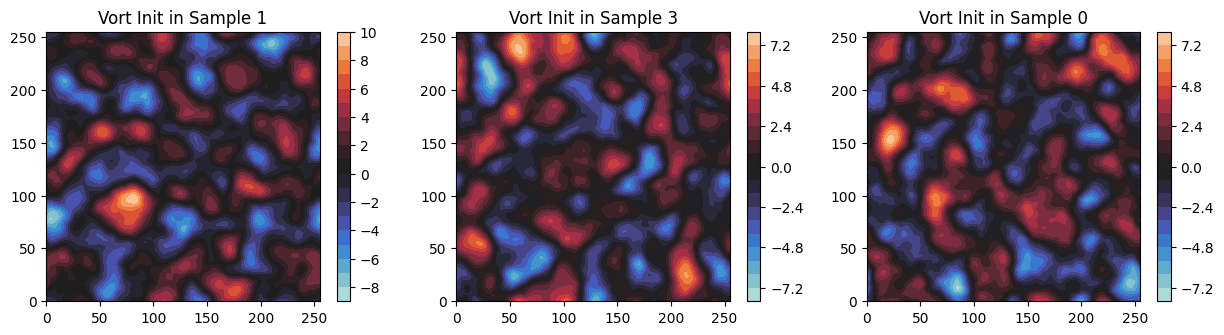

In [3]:
idxes = torch.randperm(batch_size)[:3]
fig, axs = plt.subplots(1, 3, figsize=(15, 3.5))
for i, idx in enumerate(idxes):
    contour = axs[i].contourf(vort_init.data[idx].cpu(), cmap=sns.cm.icefire, levels=20)
    plt.colorbar(contour, ax=axs[i])
    axs[i].set_title(f"Vort Init in Sample {idx}")
plt.show()

In [9]:
ns2d = NavierStokes2DSpectral(
    viscosity=viscosity,
    grid=grid,
    drag=0.1,
    smooth=True,
    forcing_fn=forcing_fn,
    solver=RK4CrankNicolsonStepper(),
).to(device)

result = get_trajectory_imex(
    ns2d, vort_hat, dt, 
    num_steps=num_steps, 
    record_every_steps=record_iters, pbar=True
)
vort = fft.irfft2(result["vorticity"]).cpu()

velocity = spectral_rot_2d(result["stream"].to(device), grid.rfft_mesh())
velocity = torch.stack(velocity, dim=-3).cpu()
velocity = fft.irfft2(velocity)
vort_t = fft.irfft2(result["vort_t"]).cpu()

  0%|          | 0/10000 [00:00<?, ?it/s]

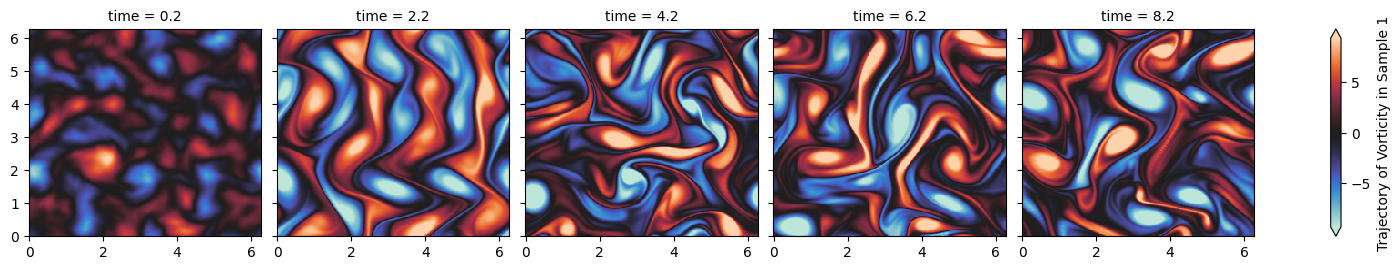

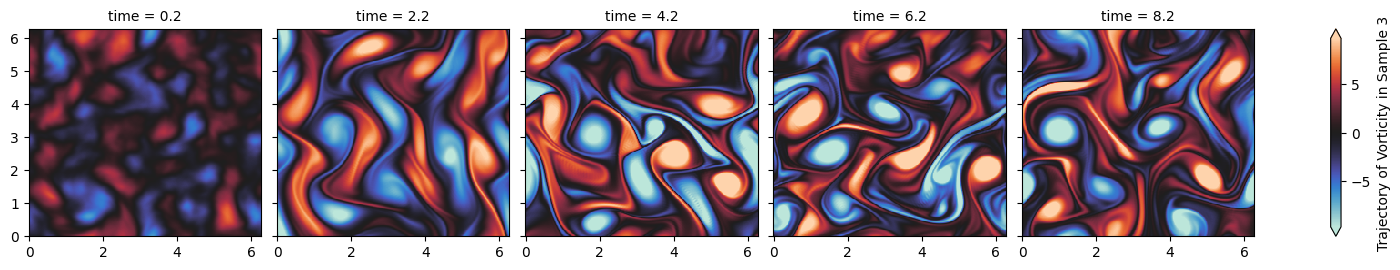

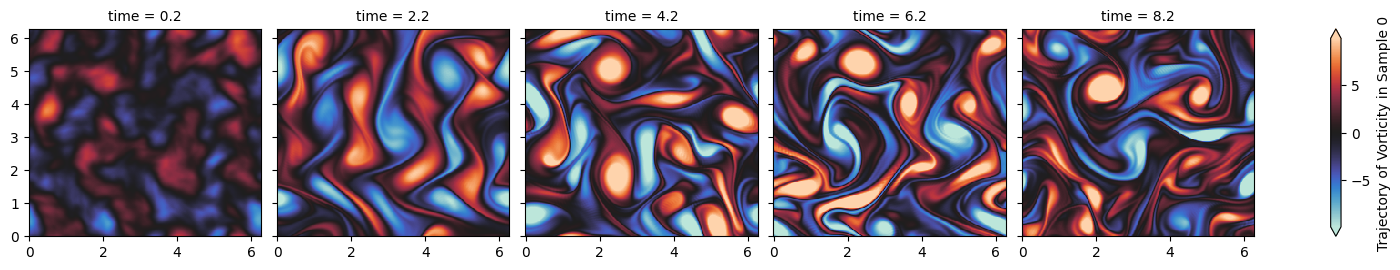

In [10]:
gridx = gridy = torch.arange(n) * 2 * torch.pi / n
coords = {
    "time": record_iters * dt * torch.arange(num_snapshots),
    "x": gridx,
    "y": gridy,
}

for idx in idxes:
    w_data = xarray.DataArray(vort[idx, :num_snapshots], dims=["time", "x", "y"], coords=coords).to_dataset(
        name="vorticity"
    )

    g = w_data["vorticity"].isel(time=slice(2, None)).thin(time=20).plot.imshow(
        col="time", col_wrap=5, cmap=sns.cm.icefire, robust=True,
        xticks=None, yticks=None,
        cbar_kwargs={"label": f'Trajectory of Vorticity in Sample {idx}'}
    )

    g.set_xlabels("")
    g.set_ylabels("")


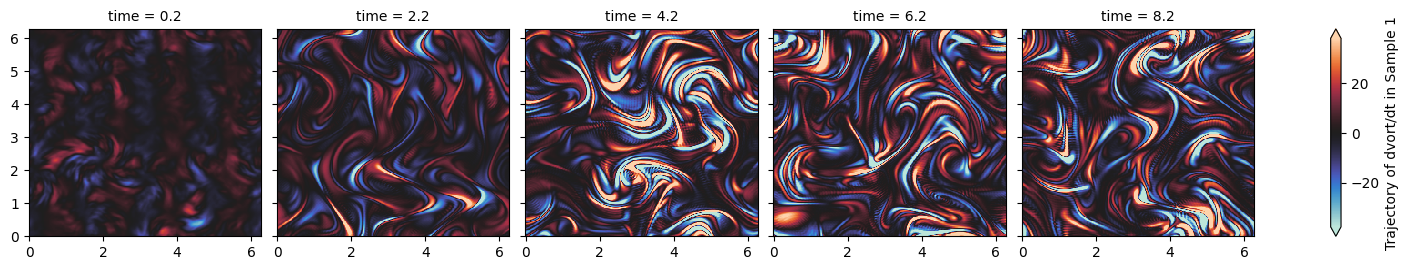

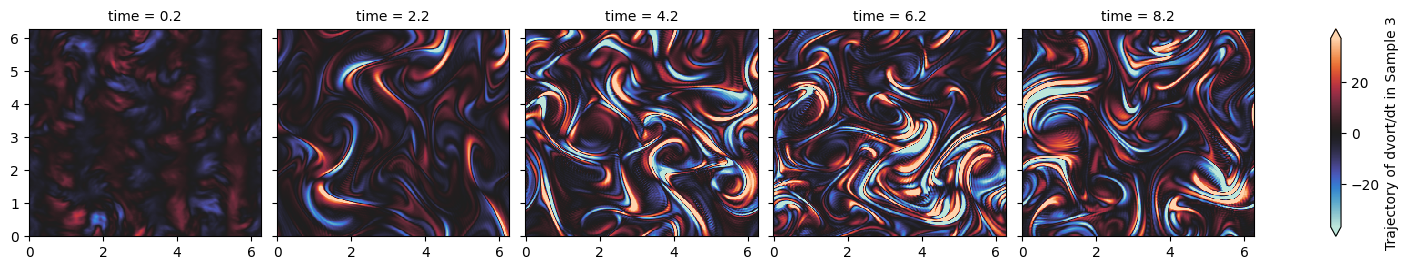

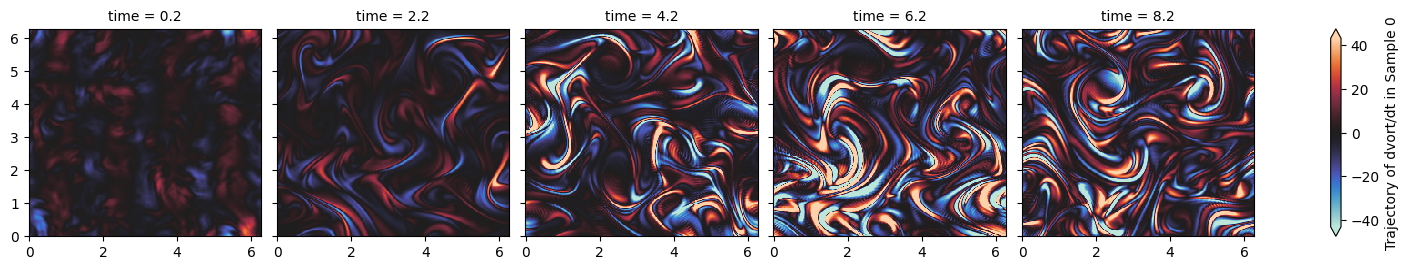

In [11]:
for idx in idxes:
    wt_data = xarray.DataArray(vort_t[idx, :num_snapshots], dims=["time", "x", "y"], coords=coords).to_dataset(
        name="vort_t"
    )
    g = wt_data["vort_t"].isel(time=slice(2, None)).thin(time=20).plot.imshow(
        col="time", col_wrap=5, cmap=sns.cm.icefire, robust=True,
        xticks=None, yticks=None,
        cbar_kwargs={"label": f'Trajectory of dvort/dt in Sample {idx}'}
    )
    g.set_xlabels("")
    g.set_ylabels("")

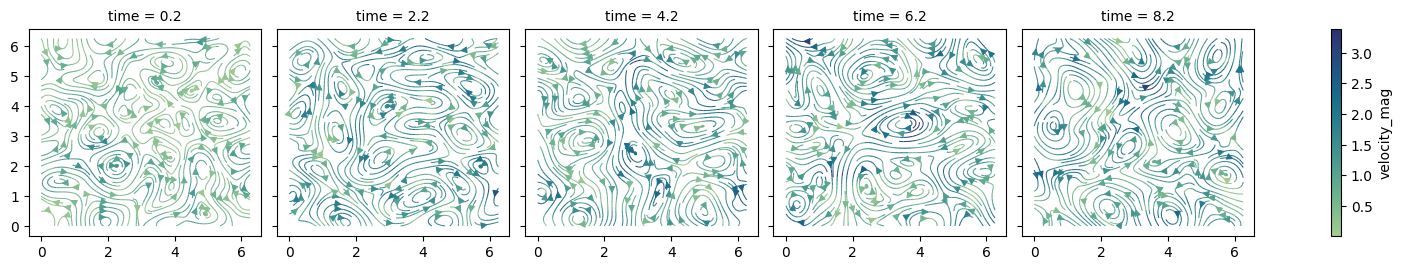

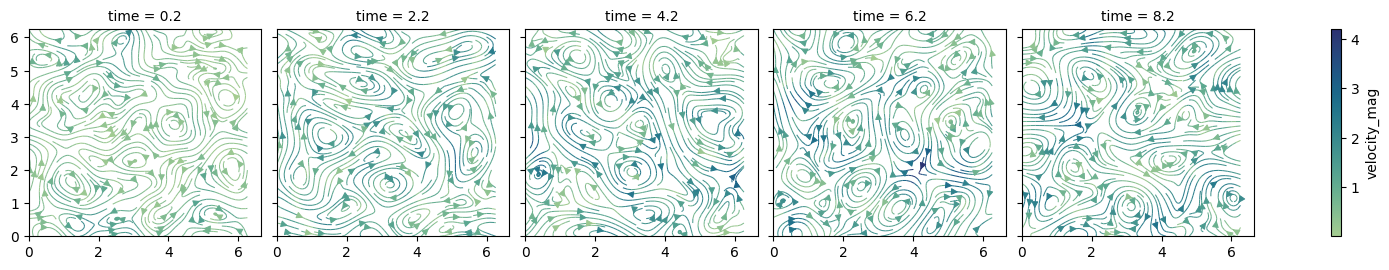

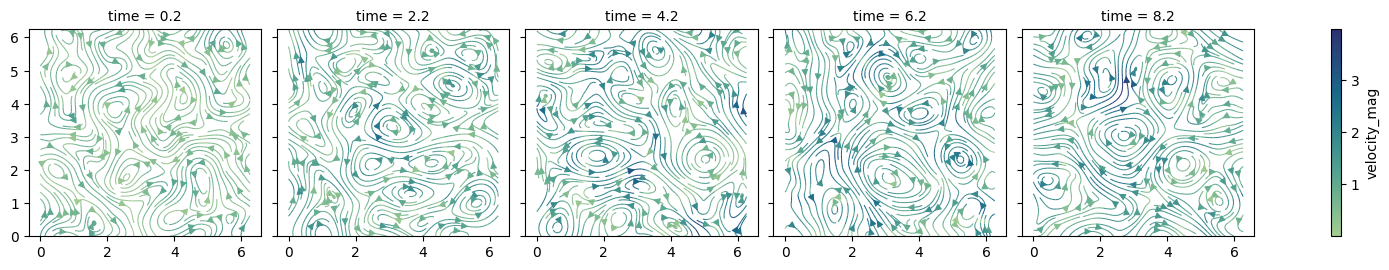

In [12]:
for idx in idxes:
    u_data = xarray.DataArray(
        velocity[idx,:num_snapshots,0], dims=["time", "x", "y"], coords=coords
    ).to_dataset(name="u")

    v_data = xarray.DataArray(
        velocity[idx,:num_snapshots,1], dims=["time", "x", "y"], coords=coords
    ).to_dataset(name="v")

    velocity_mag = torch.sqrt(velocity[idx,:num_snapshots].pow(2).sum(dim=-3))

    vmag_data = xarray.DataArray(
        velocity_mag, dims=["time", "x", "y"], coords=coords
    ).to_dataset(name="velocity_mag")

    data = xarray.merge([u_data, v_data, vmag_data])

    g = data.isel(time=slice(2, None)).thin(time=20).plot.streamplot(
        x="x",
        y="y",
        u="u",
        v="v",
        hue="velocity_mag",
        linewidth=0.75,
        col="time",
        col_wrap=5,
        cmap=sns.cm.crest,
        density=1.6,
        broken_streamlines=True,
    )
    g.set_xlabels("")
    g.set_ylabels("")